---
### **<p style="text-align: center; text-decoration: underline;">Natural Language Processing</p>**
# **<p style="text-align: center;">Practical: A bit of Morphological Warm up</p>**
---

> Realized by: *Zakaria Boulkhir* & *Omar Iken*.

> Master 2, Data Science, Lille University.

---

### ■ __Overview__
The objective of this part is to write down a very simple system that predict morphological attributes. To do so, we will use the data available [here](https://github.com/sigmorphon2020/task0-data). Then, we will pick a language we do not speak, for instance *Swahili (swa)*, and we explore the data.

### ■ **<a name="content">Contents</a>**

- [1. Dataset](#section1)

- [2. Simple baseline](#section2)

- [3. Prefix-based approach](#section3)


### ■ **Libraries**

In [1]:
## numpy to handle arrays & matices
import numpy as np

## matplotlib & Seaborn to plot figures
import matplotlib.pyplot as plt
import seaborn as sns

## pandas to handle dataframes
import pandas as pd
from scipy import stats
from tqdm import tqdm
import codecs
import os
from utils.utils import *
import unidecode

In [2]:
#-----------< Setting >------------#
## set plots text font size & style
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print(f'numpy version : {np.__version__}')
print(f'pandas version: {pd.__version__}')

numpy version : 1.20.1
pandas version: 1.2.4


### ■ **<a name="section1">1. Dataset</a>** [(&#8593;)](#content)


#### **1.1. Load data**
Let's start by laoding our dataset, and then pick a random language from the set of languages. For instance, the *swahli (swa)* language. 

In [3]:
## file path
train_file = 'data/DEVELOPMENT-LANGUAGES/niger-congo/swa.trn'
test_file = 'data/GOLD-TEST/swa.tst'

## dataframe
df_train = read_file(train_file)
df_test = read_file(test_file)

## number of training & testing samples
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print(f'Number of training samples: {n_train}')
print(f'Number of testing samples : {n_test}')

## dispaly some samples
df_train.head()

Number of training samples: 3374
Number of testing samples : 910


,lemma,form,attributes
0,piga,amepiga,V;PRF;FIN;IND;SG;3;PST
1,kamilisha,wangekamilisha,V;FIN;COND;PL;3;PRS
2,fuata,walifuata,V;FIN;IND;PL;3;PST
3,tengeneza,nitatengeneza,V;FIN;IND;SG;1;FUT
4,uwa,anauwa,V;DEF;FIN;IND;SG;3;PRS


#### **1.2. Unzip attributes:** 
Now, we will extract the individual attributes for each form. For instance, the attributes for *amepiga* are *{V;PRF;FIN;IND;SG;3;PST}*, so unziping means creating a new sample for each of the morphological attributes. 

In [4]:
def unzip_attrs(df):
    """"""
    ## unzip attributes
    df_unzip = []

    for idx in df.index:
        lemma, form, attrs = df.iloc[idx].to_list()

        for attr in attrs.split(';'):
            df_unzip.append([lemma, form, attr])
        
    ## create a new dataframe  
    df_unzip = pd.DataFrame(df_unzip, columns=df.columns)
        
    return df_unzip

## unzip attributes
df_train_unzip = unzip_attrs(df_train)
df_train_unzip.head()

,lemma,form,attributes
0,piga,amepiga,V
1,piga,amepiga,PRF
2,piga,amepiga,FIN
3,piga,amepiga,IND
4,piga,amepiga,SG


#### **1.3. Data exploration**
Let's do a bit of data exploration: count the number of characters, n-grams, etc.

##### **1.3.1. Unique Characters:**
Get the unique the characters of the language.

In [5]:
## get the number of unique characters
text = ''.join(df_train[['lemma', 'form']].to_numpy().flatten())

## get (number of) unique characters
unique_chars = sorted(set(text))
n_chars = len(unique_chars)

print(f"> Number of unique characters: {n_chars}\n> Characters: {', '.join(unique_chars)}")

> Number of unique characters: 24
> Characters: a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, r, s, t, u, v, w, y, z


##### **1.3.2. Morphological attributes:** 
histogram of different attributes, this will allow us to see which one is dominating.

In [6]:
## get unique morphological attributes
morph_attrs = ';'.join(df_train['attributes'].to_list()).split(';')
morph_attrs = np.asarray(morph_attrs)
unique_attrs = sorted(set(morph_attrs)) ## sort to keep same order
n_attrs = len(unique_attrs)

print(f"> Number of unique morphological attributes: {n_attrs}\n> Morphological attributes: {', '.join(unique_attrs)}")

> Number of unique morphological attributes: 16
> Morphological attributes: 1, 2, 3, COND, DEF, FIN, FUT, HAB, IND, INDF, PL, PRF, PRS, PST, SG, V


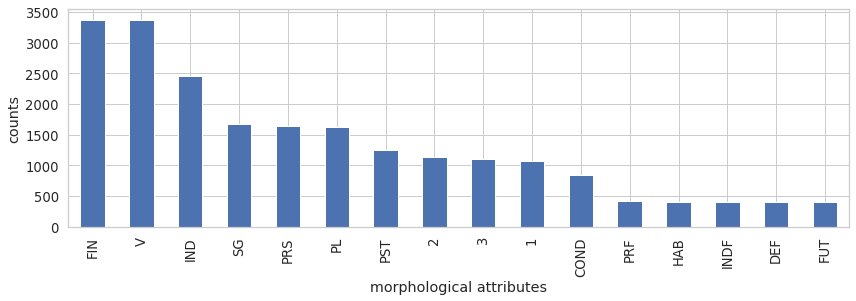

In [7]:
## plot attributes count
fig, ax = plt.subplots(figsize=(14, 4))
df_train_unzip['attributes'].value_counts().plot.bar(ax=ax)
ax.set_xlabel('morphological attributes')
ax.set_ylabel('counts')
plt.show()

##### **Train & Test sets**

In [8]:
## get features & labels for training data
X_train, y_train = df_train_unzip[['lemma', 'form']].to_numpy(), df_train_unzip['attributes'].to_numpy()
X_test, y_test = df_train_unzip[['lemma', 'form']].to_numpy(), df_test['attributes'].to_numpy()

### ■ **<a name="section2">2. Simple baseline</a>** [(&#8593;)](#content)
Now we will write a super simple baseline using 5 rules to predict morphological attributes. This baseline consists of predicting the morphological attribute of a given form and lemma using one of the five rules:
- *Mode*: predict returns the mode of the training labels.
- *prior*: predict returns the prior element of the training labels.
- *stratified* : predict returns an attribute of the training labels in a uniform way.
- *uniform*: predict returns an attribute in a uniform way from unique attributes.
- *constant*: predict returns a constant attribute from the learning labels.

#### **2.1. Simple baseline to predict morphological attributes**


In [9]:
class SimpleBaseline:
    
    """Simple Baseline to predict the morphological attribute of a given lemma and form
    
    Parameters
    ----------
    rule: str,
        The rule to use to predict the attribute.
        
    Attributes
    ----------
    rules: set,
        The set of available rules.
    """
    
    def __init__(self, rule='mode'):
        self.rule = rule
        self.rules = {"mode", "prior", "stratified", "uniform", "constant"}
        
    def fit(self, X, y):
        """fit the model"""
        self.y = y
        
        return self
        
    def predict(self, x):
        """predict the attribute from x"""
        
        if self.rule not in self.rules:
            raise Exception(f'rule should be in {self.rules}')
            
        if self.rule in ['mode', 'prior']:
            y = stats.mode(self.y)[0][0]
            
        elif self.rule == 'uniform':
            y = np.random.choice(np.unique(self.y))
            
        elif self.rule == 'stratified':
            size = np.random.choice(len(set(self.y)))
            y = np.random.choice(self.y, size=size)
            
        elif self.rule == 'constant':
            y = self.y[0]
        
        return y
    
    def __repr__(self):
        return 'SimpleBaseline'

In [10]:
## create a simple baseline
baseline = SimpleBaseline(rule='stratified')

## fir the baseline model
baseline.fit(X_train, y_train)

## test the baseline
baseline.predict(['piga', 'amepiga'])

array(['SG', 'IND', 'COND', 'V', 'V', 'IND', 'V', '1', 'IND', '1', 'COND',
       'PST', 'IND'], dtype=object)

### ■ **<a name="section3">3. Prefix-based approach</a>** [(&#8593;)](#content)

This new very simple approach relies on extracting the prefix of form and lemma and use it to make preidctions. 
#### **3.1. Overview** 
Extract the prefix of each lemma from each form will allow us to see which prefix are most correlated with different attributes. 

In [13]:
def get_prefix(lemma, form):
    """returns the prefix from the given lemma & form"""
    
    if lemma in form:
        return form.replace(lemma, '')
    return ''

In [14]:
## add prefix column to dataframe
df_train_unzip['prefix'] = df_train_unzip.apply(lambda x: get_prefix(x.lemma, x.form), axis=1)
df_train_unzip.head()

,lemma,form,attributes,prefix
0,piga,amepiga,V,ame
1,piga,amepiga,PRF,ame
2,piga,amepiga,FIN,ame
3,piga,amepiga,IND,ame
4,piga,amepiga,SG,ame


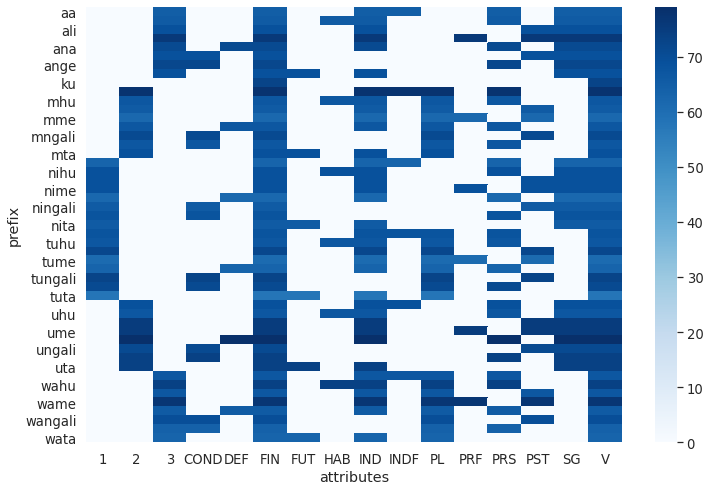

In [15]:
## count number of prefix per attributes
corr = pd.crosstab(index=df_train_unzip['prefix'], columns=df_train_unzip['attributes'])

## display
fig, ax = plt.subplots()
sns.heatmap(corr, ax=ax, cmap='Blues')
plt.show()

>**Idea:** one can use this correlation matrix to predict the mophological attributes of a given form & lemma

#### **3.2. Prefix-based model**
One can predict using the prefix rule given above, for instance, get the prefix from the given form and lemma, and return the attribute which is most correlated with the prefix.

In [16]:
class PrefixRule:
    """PrefixRule"""
    
    def __init__(self):
        ...
        
    def fit(self, X, y):
        """to fit the model"""
        ## get prefixes
        prefixes = [get_prefix(lemma, form) for lemma, form in X]
        ## unique prefixes
        self.prefixes = set(prefixes)
        ## compute correlation
        df = pd.DataFrame([prefixes, y], index=['prefix', 'attribute']).T
        self.corr = pd.crosstab(df['prefix'], df['attribute'])
        
        return self
        
    def predict(self, x):
        ## get prefix
        lemma, form = x
        prefix = get_prefix(lemma, form)
        
        ## check that prefix is included in the list of prefix
        if prefix not in self.prefixes:
            raise Exception(f'prefix should be in {self.prefixes}')
            
        ## get attributes which are most correlated with prefix
        max_val = self.corr.loc[prefix].max()
        pred_attrs = self.corr.loc[prefix][self.corr.loc[prefix] == max_val].index.to_numpy()
        
        return pred_attrs
    
    def __repr__(self):
        return 'PrefixRule'

In [17]:
## create & fit the model
prefix_rule = PrefixRule()
prefix_rule.fit(X_train, y_train)

PrefixRule

In [18]:
## pick random lemma & form
lemma, form = X_train[np.random.randint(len(X_train))]

## make predictions
pred_attrs = prefix_rule.predict([lemma, form])

print(f"> The predicted attributes for ({lemma}, {form}):\t {', '.join(pred_attrs)}")

## get true attributes
true_attrs = df_train_unzip[(df_train_unzip['lemma'] == lemma) & (df_train_unzip['form'] == form)]['attributes']
print(f"> The true attributes for ({lemma}, {form})\t:\t {', '.join(true_attrs)}")

> The predicted attributes for (pea, anapea):	 3, DEF, FIN, IND, PRS, SG, V
> The true attributes for (pea, anapea)	:	 V, DEF, FIN, IND, SG, 3, PRS


>**Comments:** 
>- This new model is more interesting because it can predict more than one attribute for a given lemma and form.
>- But one of its main drawbacks is that it only takes into account prefixes that are in the training set.

### **References** 
@article{vylomova2020sigmorphon, title={SIGMORPHON 2020 Shared Task 0: Typologically Diverse Morphological Inflection}, author={Vylomova, Ekaterina and White, Jennifer and Salesky, Elizabeth and Mielke, Sabrina J and Wu, Shijie and Ponti, Edoardo and Maudslay, Rowan Hall and Zmigrod, Ran and Valvoda, Josef and Toldova, Svetlana and others}, journal={SIGMORPHON 2020}, pages={1}, year={2020} }

---
<p style="text-align: center;">Copyright © 2021 Omar Ikne & Zakaria Boulkhir</p>